A partir del archivo Euro_2012_stats_TEAM, se pide:

1. Obtener la matriz de correlación. ¿Qué columnas están mejor correlacionadas?

2. ¿Existe algún tipo de relación entre la precisión de disparo a puerta (Shooting Accuracy) con respecto a los goles? Muestra en una gráfica (pintando la línea en la distribución de ambas variables) y usando Regresión Lineal, Regresión no Lineal con polinomio y SVR la relación entre ambos. Por cada porcentaje de acierto de cara a puerta, ¿cuánto aumenta o disminuye el número de goles? 

3. Si tratamos la columna Goals como una columna categórica y usando logistic regression, SVM y Random forest, ¿cuántos goles marcaría un equipo que tiene...? (por cada algoritmo):

    - % de goles por disparo: 40%
    - Total shots (inc. Blocked): 102
    - Corners Taken: 5
    - Passes: 82
    - Dribbles: 23

In [152]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR, LinearSVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import linear_model

In [86]:
df = pd.read_csv("../data/Euro_2012_stats_TEAM.csv")
df.head(2)

,Team,Goals,Shots on target,Shots off target,Shooting Accuracy,% Goals-to-shots,Total shots (inc. Blocked),Hit Woodwork,Penalty goals,Penalties not scored,...,Saves made,Saves-to-shots ratio,Fouls Won,Fouls Conceded,Offsides,Yellow Cards,Red Cards,Subs on,Subs off,Players Used
0,Croatia,4,13,12,51.9%,16.0%,32,0,0,0,...,13,81.3%,41,62,2,9,0,9,9,16
1,Czech Republic,4,13,18,41.9%,12.9%,39,0,0,0,...,9,60.1%,53,73,8,7,0,11,11,19


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Team                        16 non-null     object 
 1   Goals                       16 non-null     int64  
 2   Shots on target             16 non-null     int64  
 3   Shots off target            16 non-null     int64  
 4   Shooting Accuracy           16 non-null     object 
 5   % Goals-to-shots            16 non-null     object 
 6   Total shots (inc. Blocked)  16 non-null     int64  
 7   Hit Woodwork                16 non-null     int64  
 8   Penalty goals               16 non-null     int64  
 9   Penalties not scored        16 non-null     int64  
 10  Headed goals                16 non-null     int64  
 11  Passes                      16 non-null     int64  
 12  Passes completed            16 non-null     int64  
 13  Passing Accuracy            16 non-nu

In [88]:
# Functions for the cleaning

def num_cleaning(x):
    try:
        return re.match(r'[\d]*[\.\d]*', x)[0]
    except:
        return x

def to_float(x):
    try:
        return float(x)
    except:
        return x

def mapper(data):
    try:
        data.shape[1]       # This is actually to check whether it is a DataFrame or not
        return data.applymap(num_cleaning).applymap(to_float)
    except:
        return data.map(num_cleaning).map(to_float)

In [89]:
df = mapper(df)
df.head(2)

,Team,Goals,Shots on target,Shots off target,Shooting Accuracy,% Goals-to-shots,Total shots (inc. Blocked),Hit Woodwork,Penalty goals,Penalties not scored,...,Saves made,Saves-to-shots ratio,Fouls Won,Fouls Conceded,Offsides,Yellow Cards,Red Cards,Subs on,Subs off,Players Used
0,,4.0,13.0,12.0,51.9,16.0,32.0,0.0,0.0,0.0,...,13.0,81.3,41.0,62.0,2.0,9.0,0.0,9.0,9.0,16.0
1,,4.0,13.0,18.0,41.9,12.9,39.0,0.0,0.0,0.0,...,9.0,60.1,53.0,73.0,8.0,7.0,0.0,11.0,11.0,19.0


### 1) Obtener la matriz de correlación. ¿Qué columnas están mejor correlacionadas?

In [90]:
corr = df.corr()

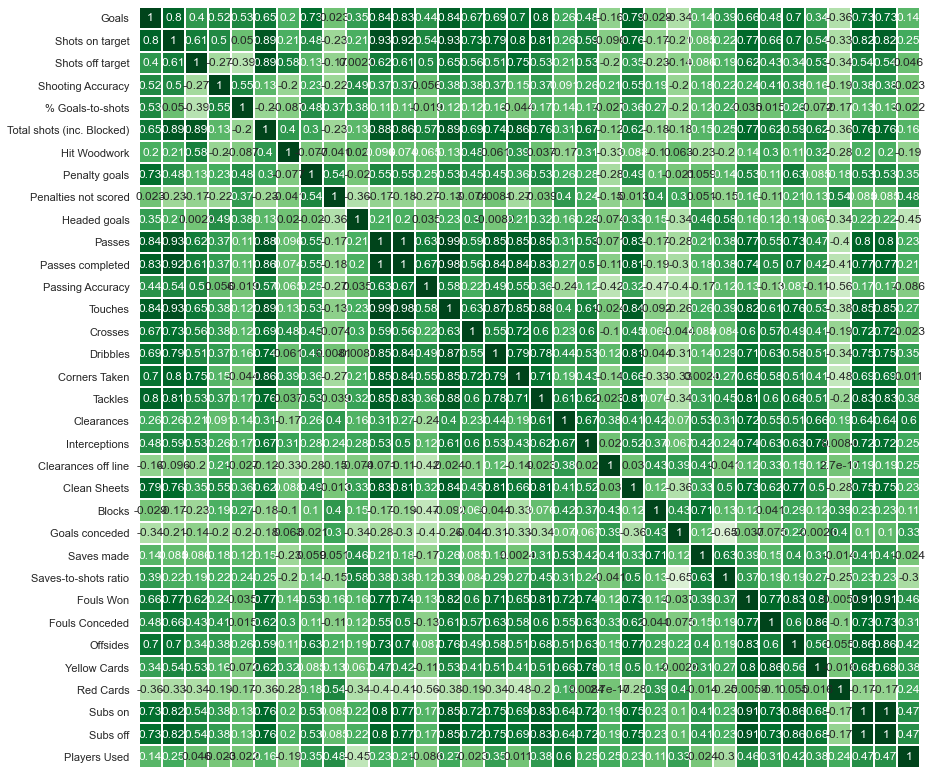

In [91]:
plt.figure(figsize = (14, 14))

sns.heatmap(corr, annot = True, linewidths = .1, cbar = False, xticklabels = False, center = 0, cmap = "Greens")

plt.show()

In [92]:
def get_feature_correlation(df, top_n=None, corr_method='spearman',
                            remove_duplicates=True, remove_self_correlations=True):
    """
    Compute the feature correlation and sort feature pairs based on their correlation

    :param df: The dataframe with the predictor variables
    :type df: pandas.core.frame.DataFrame
    :param top_n: Top N feature pairs to be reported (if None, all of the pairs will be returned)
    :param corr_method: Correlation compuation method
    :type corr_method: str
    :param remove_duplicates: Indicates whether duplicate features must be removed
    :type remove_duplicates: bool
    :param remove_self_correlations: Indicates whether self correlations will be removed
    :type remove_self_correlations: bool

    :return: pandas.core.frame.DataFrame
    """
    corr_matrix_abs = df.corr(method=corr_method).abs()
    corr_matrix_abs_us = corr_matrix_abs.unstack()
    sorted_correlated_features = corr_matrix_abs_us \
        .sort_values(kind="quicksort", ascending=False) \
        .reset_index()

    # Remove comparisons of the same feature
    if remove_self_correlations:
        sorted_correlated_features = sorted_correlated_features[
            (sorted_correlated_features.level_0 != sorted_correlated_features.level_1)
        ]

    # Remove duplicates
    if remove_duplicates:
        sorted_correlated_features = sorted_correlated_features.iloc[:-2:2]

    # Create meaningful names for the columns
    sorted_correlated_features.columns = ['Feature 1', 'Feature 2', 'Correlation (abs)']

    if top_n:
        return sorted_correlated_features[:top_n]

    return sorted_correlated_features

In [93]:
get_feature_correlation(df, 15)

,Feature 1,Feature 2,Correlation (abs)
21,Subs off,Subs on,1.000000
36,Passes,Passes completed,0.988235
38,Touches,Passes,0.952941
40,Touches,Passes completed,0.947059
42,Corners Taken,Passes completed,0.929995
44,Corners Taken,Passes,0.921152
46,Total shots (inc. Blocked),Shots off target,0.902441
48,Corners Taken,Touches,0.884306
50,Touches,Dribbles,0.863871
52,Total shots (inc. Blocked),Passes completed,0.863035


In [94]:
# Aquí podemos ver las variables más correlacionadas --> Está en valor absoluto, para más detalle chequear directamente la matriz o el heatmap

### ¿Existe algún tipo de relación entre la precisión de disparo a puerta (Shooting Accuracy) con respecto a los goles? Muestra en una gráfica (pintando la línea en la distribución de ambas variables) y usando Regresión Lineal, Regresión no Lineal con polinomio y SVR la relación entre ambos. Por cada porcentaje de acierto de cara a puerta, ¿cuánto aumenta o disminuye el número de goles?

In [95]:
corr.loc["Goals", "Shooting Accuracy"]

0.5212095324544347

<Figure size 1008x720 with 0 Axes>

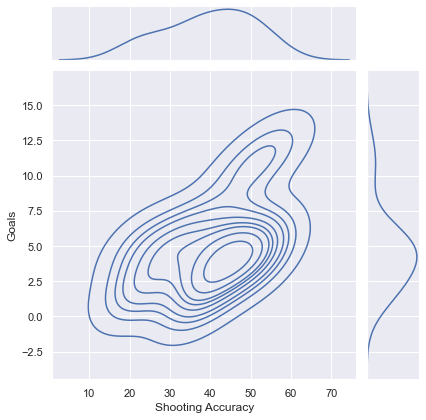

In [96]:
# This is out plot without any model
sns.set_theme()

plt.figure(figsize = (14, 10))

plot = sns.jointplot(x = df["Shooting Accuracy"], y = df["Goals"], kind = "kde")
#plot.ax_joint.plot([4,8], [2,5], 'b-', linewidth = 2)

In [97]:
### Independent variable
X = df["Shooting Accuracy"]
x_ = np.array(X).reshape(-1, 1)

### Dependent variable
y = df["Goals"]

### Models
# Linear
linear_model = LinearRegression()

# Polinomial
polinomial_model = PolynomialFeatures(3)
x_poly = polinomial_model.fit_transform(x_, y)
linear_pol_model = LinearRegression()

# SVR
svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)

### Training
# Linear
linear_model.fit(x_, y)

# Polinomial
linear_pol_model.fit(x_poly, y)

# SVR
svr.fit(x_, y)

### Predictions
# Linear
y_pred_linear = linear_model.predict(x_)

# Polinomial
y_pred_pol = linear_pol_model.predict(x_poly)

# SVR
y_pred_svr = svr.predict(x_)

### Scores
# Linear
linear_score = linear_model.score(x_, y)

# Polinomial
pol_score = r2_score(y, y_pred_pol)

# SVR
svr_score = svr.score(x_, y)

print(f"Linear model score: {linear_score}")
print(f"Polinomial model score: {pol_score}")
print(f"SVR model score: {svr_score}")

Linear model score: 0.2716593767213703
Polinomial model score: 0.4443383420925051
SVR model score: 0.9188930591481695


<Figure size 1008x720 with 0 Axes>

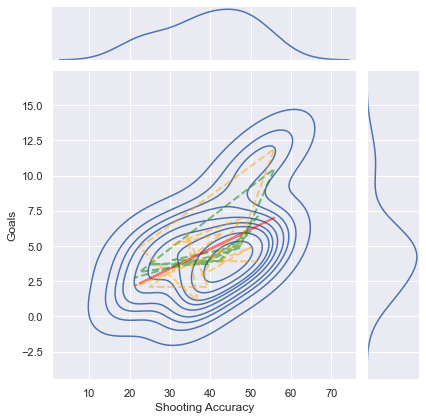

In [98]:
# This is out plot without any model
sns.set_theme()

plt.figure(figsize = (14, 10))

plot = sns.jointplot(x = df["Shooting Accuracy"], y = df["Goals"], kind = "kde")
plot.ax_joint.plot(x_, y_pred_linear, '--', linewidth = 2, color = "red", alpha = .5)
plot.ax_joint.plot(x_, y_pred_pol, '--', linewidth = 2, color = "green", alpha = .5)
plot.ax_joint.plot(x_, y_pred_svr, '--', linewidth = 2, color = "orange", alpha = .5)

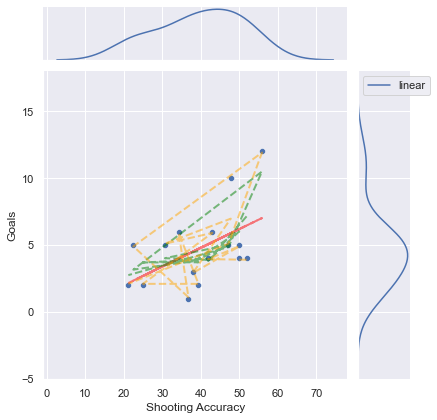

In [99]:
g = sns.JointGrid(x = df["Shooting Accuracy"], y = df["Goals"])
g.plot(sns.scatterplot, sns.kdeplot)

g.ax_joint.plot(x_, y_pred_linear, '--', linewidth = 2, color = "red", alpha = .5)
g.ax_joint.plot(x_, y_pred_pol, '--', linewidth = 2, color = "green", alpha = .5)
g.ax_joint.plot(x_, y_pred_svr, '--', linewidth = 2, color = "orange", alpha = .5)

plt.legend(["linear", "polinomial", "SVR"])

#### Por cada porcentaje de acierto de cara a puerta, ¿cuánto aumenta o disminuye el número de goles?

Esta pregunta es difícil de determinar con los modelos polinomial y SVR, por su complejidad matemática. Sin embargo, el modelo de regresión lineal simple es mucho más interpretable (aunque impreciso también). Veamos que sacamos de cada modelo. 

In [100]:
# Linear regresion
print("Slope: ", linear_model.coef_[0])

Slope:  0.1398143987243285


In [101]:
# A 1% increase in the shooting accuracy would increase the amount of goals by 0.1398

In [102]:
# Polinomial regresion

# In this case, as the coeficients' interpretation is noy so straight forward, we will calculate several points and see the change
shooting_accuracy = [40.0, 45.0, 50.0, 55.0, 60.0]

x_poly_2 = polinomial_model.fit_transform(np.array(shooting_accuracy).reshape(-1, 1))

pol_pred = linear_pol_model.predict(x_poly_2)

print("Shooting accuracy:\n", shooting_accuracy)
print("#" * 50)
print("Polinomial transformations:\n", x_poly_2)
print("#" * 50)
print("Predicted goals:\n", pol_pred)

Shooting accuracy:
 [40.0, 45.0, 50.0, 55.0, 60.0]
##################################################
Polinomial transformations:
 [[1.00000e+00 4.00000e+01 1.60000e+03 6.40000e+04]
 [1.00000e+00 4.50000e+01 2.02500e+03 9.11250e+04]
 [1.00000e+00 5.00000e+01 2.50000e+03 1.25000e+05]
 [1.00000e+00 5.50000e+01 3.02500e+03 1.66375e+05]
 [1.00000e+00 6.00000e+01 3.60000e+03 2.16000e+05]]
##################################################
Predicted goals:
 [ 3.72038912  4.25583722  6.02301856  9.60266073 15.57549134]


In [103]:
# We can see that the change is not linear, as we would have expected. Since it is not a linear regresion, the slope (slopes in this case) won't be linear. We can see that, the higher the shooting accuracy, the higher the impact of a small increase in the number of goals. This somehow makes sense, because even if we increase from 10% to 15%, it is still quite unlikely for the team to score.

In [104]:
# SVR
# We'll do the as me for the polinomial model: we'll predict a bunch of points and see the change

svr_pred = svr.predict(np.array(shooting_accuracy).reshape(-1, 1))

print("Shooting accuracy:\n", shooting_accuracy)
print("#" * 50)
print("Predicted goals:\n", svr_pred)

Shooting accuracy:
 [40.0, 45.0, 50.0, 55.0, 60.0]
##################################################
Predicted goals:
 [ 1.33488127  2.10235231  4.89989107 11.77798425  5.63649396]


In [105]:
# This model has the better score, meaning that is the best one for predictions.
# As we can see, the change isn't linear for this model either, what it's consistent with the transformations the model makes.
# In terms of change, we see that the increase in shooting accuracy has a positive impact of the goals amount up to a certain point, where this starts to fall.
# This is reasonable too, as the goals don't only depend on the shooting accuracy but on other factors too.

### Si tratamos la columna Goals como una columna categórica y usando logistic regression, SVM y Random forest, ¿cuántos goles marcaría un equipo que tiene...? (por cada algoritmo):
    - % de goles por disparo: 40%
    - Total shots (inc. Blocked): 102
    - Corners Taken: 5
    - Passes: 82
    - Dribbles: 23

In [146]:
# As we need to predict but we are only receiving data for some of the independent variables, I'll fill in the rest with the means. This way, we'll have a "centered" prediction

# Variable means
to_predict = df.drop(["Team", "Goals"], axis = 1)
to_predict = to_predict.describe().loc["mean"]

# Replacing the given values
to_predict["% Goals-to-shots"] = 40
to_predict["Total shots (inc. Blocked)"] = 102
to_predict["Corners Taken"] = 5
to_predict["Passes"] = 82
to_predict["Dribbles"] = 23

# Transformation for fit
to_predict = np.array(to_predict).reshape(1, -1)

In [116]:
# The NAs are causing some trouble, so let's drop them
df2 = df.dropna()
df2.head(1)

,Team,Goals,Shots on target,Shots off target,Shooting Accuracy,% Goals-to-shots,Total shots (inc. Blocked),Hit Woodwork,Penalty goals,Penalties not scored,...,Saves made,Saves-to-shots ratio,Fouls Won,Fouls Conceded,Offsides,Yellow Cards,Red Cards,Subs on,Subs off,Players Used
1,,4.0,13.0,18.0,41.9,12.9,39.0,0.0,0.0,0.0,...,9.0,60.1,53.0,73.0,8.0,7.0,0.0,11.0,11.0,19.0


In [143]:
# Independent variables
X2 = df2.drop(["Team", "Goals"], axis = 1)

# Dependent variable
y2 = np.array(df2["Goals"].apply(round))

In [147]:
# SVM

# Model
svm = LinearSVC(max_iter = 1000000, C = 100, random_state = 1)

# Training
svm.fit(X2, y2)

# Prediction
svm_prediction = svm.predict(to_predict)

print("SVM - Goals prediction for the team:", svm_prediction)

SVM - Goals prediction for the team: [2]


In [140]:
# So, with SVM we would expect this team to score 2 goals

In [153]:
# Random Forest

# Model
randomforest = RandomForestClassifier(max_depth = 30, random_state = 3)

# Training
randomforest.fit(X2, y2)

# Prediction
rf_prediction = randomforest.predict(to_predict)

print("Random Forest - Goals prediction for the team:", rf_prediction)

Random Forest - Goals prediction for the team: [5]


In [151]:
# So, with Random Forest we would expect this team to score 5 goals

In [156]:
# Logistic Regression

# Model
logistic = linear_model.LogisticRegression(max_iter = 10000)

# Training
logistic.fit(X2, y2)

# Prediction
log_prediction = logistic.predict(to_predict)

print("Logistic Regression - Goals prediction for the team:", log_prediction)

Logistic Regression - Goals prediction for the team: [2]


In [157]:
# So, with Logistic Regression we would expect this team to score 2 goals

In [158]:
# As we can see, two of the models say 2 goals and the remaining one (Random Forest) says five.

# Let's check the models' scores

print(f"SVM - Score: {svm.score(X2, y2)}")
print(f"Random Forest - Score: {randomforest.score(X2, y2)}")
print(f"Logistic Regression - Score: {logistic.score(X2, y2)}")

SVM - Score: 1.0
Random Forest - Score: 1.0
Logistic Regression - Score: 1.0


Bueno, parece que todos los modelos tienen un score de 100% (1). Igualmente, esto no es muy representatito por varios motivos:

    1- Tenemos muy pocos datos
    
    2- No hicimos el split entre test y training (precisamente porque ya eran muy pocos datos)